# Using Battery Parameter eXchange (BPX) files

In this notebook we how to import parameters defined using the [BPX standard](https://github.com/FaradayInstitution/BPX).

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import matplotlib.pyplot as plt
import numpy as np

import pybamm


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


First we load an example BPX file from the [pybamm-data](https://github.com/pybamm-team/pybamm-data/releases) repository using the `DataLoader` class. For more information on the `DataLoader` class, see the [pybamm_data](../pybamm_data.ipynb) notebook.

In [2]:
path_to_bpx_file = pybamm.DataLoader().get_data("nmc_pouch_cell_BPX.json")

We can create a `ParameterValues` object from a BPX file using the `create_from_bpx` method. We pass in the path to the BPX file.

In [3]:
parameter_values = pybamm.ParameterValues.create_from_bpx(path_to_bpx_file)

/Users/robertwtimms/Documents/PyBaMM/env/lib/python3.11/site-packages/bpx/validators.py:32: UserWarning: The maximum voltage computed from the STO limits (4.201761488607647 V) is higher than the upper voltage cut-off (4.2 V) with the absolute tolerance v_tol = 0.001 V
  warn(
/Users/robertwtimms/Documents/PyBaMM/src/pybamm/parameters/parameter_values.py:166: UserWarning: 'Open-circuit voltage at 0% SOC [V]' not found in BPX file. Using 'Lower voltage cut-off [V]'.
  return ParameterValues._create_from_bpx(bpx, target_soc)
/Users/robertwtimms/Documents/PyBaMM/src/pybamm/parameters/parameter_values.py:166: UserWarning: 'Open-circuit voltage at 100% SOC [V]' not found in BPX file. Using 'Upper voltage cut-off [V]'.
  return ParameterValues._create_from_bpx(bpx, target_soc)


Alternatively, we can create a `ParameterValues` object from a BPX JSON object as `pybamm.ParameterValues.create_from_bpx_obj(bpx_obj)`


We can take a look at the parameter values we have loaded, and interact with them like any other `ParameterValues` object. For example, we can search for parameters containing the text "Negative electrode".

In [4]:
parameter_values.search("Negative electrode")

Initial concentration in negative electrode [mol.m-3]	22496.096400000002
Maximum concentration in negative electrode [mol.m-3]	29730.0
Negative electrode Bruggeman coefficient (electrode)	0
Negative electrode Bruggeman coefficient (electrolyte)	1.5
Negative electrode OCP [V]	<function reconstructed_function at 0x17da30b80>
Negative electrode OCP entropic change [V.K-1]	<function reconstructed_function at 0x17da31580>
Negative electrode active material volume fraction	0.6860102133333333
Negative electrode conductivity [S.m-1]	0.222
Negative electrode density [kg.m-3]	1847.0
Negative electrode diffusivity [m2.s-1]	functools.partial(<function bpx_to_param_dict.<locals>._diffusivity at 0x17da31800>, D_ref=2.728e-14, Ea=30000.0, constant=True)
Negative electrode diffusivity activation energy [J.mol-1]	30000.0
Negative electrode exchange-current density [A.m-2]	functools.partial(<function bpx_to_param_dict.<locals>._exchange_current_density at 0x17da316c0>, k_ref=5.33563612557725e-07, Ea=550

Next we load a model and create a simulation, passing in our parameter values.

In [5]:
model = pybamm.lithium_ion.DFN()
sim = pybamm.Simulation(model, parameter_values=parameter_values)

Finally, we can solve the model and plot the results.

In [6]:
# solve for 1 hour
sim.solve([0, 3600])
_ = sim.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

We can also plot the parameters some of the parameters we loaded. Here we will plot the electrolyte conductivity and diffusivity, as well as the particle diffusivity, exchange-current density and open-circuit potential for the positive and negative electrodes over their respective stoichiometry ranges.

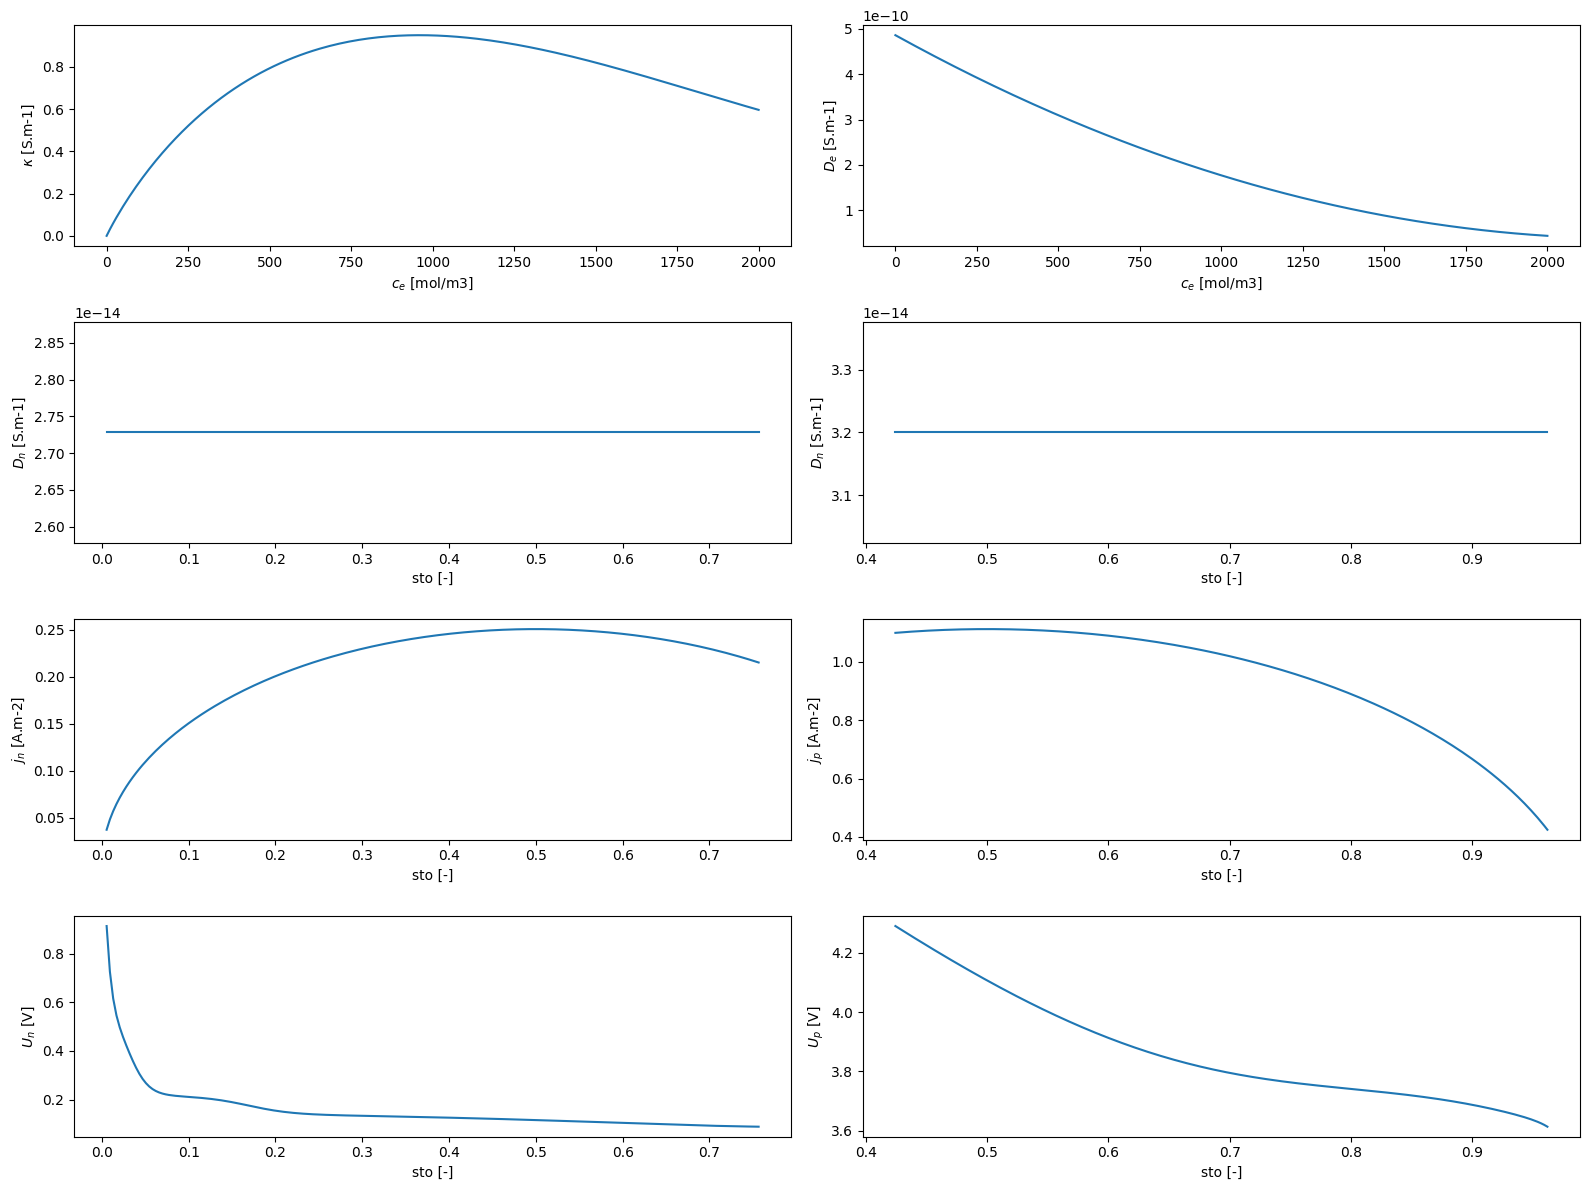

In [7]:
# define stoichiometry ranges
xLi_n_max = parameter_values["Negative electrode maximum stoichiometry"]
xLi_n_min = parameter_values["Negative electrode minimum stoichiometry"]
xLi_n = pybamm.linspace(xLi_n_min, xLi_n_max, 200)
xLi_p_max = parameter_values["Positive electrode maximum stoichiometry"]
xLi_p_min = parameter_values["Positive electrode minimum stoichiometry"]
xLi_p = pybamm.linspace(xLi_p_min, xLi_p_max, 200)

# define concentration ranges
c_n_max = parameter_values["Maximum concentration in negative electrode [mol.m-3]"]
c_p_max = parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
c_n = xLi_n * c_n_max
c_p = xLi_p * c_p_max
c_e = pybamm.linspace(0, 2000, 200)

c_e_ref = parameter_values["Initial concentration in electrolyte [mol.m-3]"]
T = parameter_values["Reference temperature [K]"]

# create figure
fig, ax = plt.subplots(4, 2, figsize=(16, 12))

ax[0, 0].plot(
    c_e.entries,
    parameter_values.evaluate(
        parameter_values["Electrolyte conductivity [S.m-1]"](c_e, T)
    ),
)
ax[0, 0].set(xlabel="$c_e$ [mol/m3]", ylabel="$\kappa$ [S.m-1]")
ax[0, 1].plot(
    c_e.entries,
    parameter_values.evaluate(
        parameter_values["Electrolyte diffusivity [m2.s-1]"](c_e, T)
    ),
)
ax[0, 1].set(xlabel="$c_e$ [mol/m3]", ylabel="$D_e$ [S.m-1]")
ax[1, 0].plot(
    xLi_n.entries,
    parameter_values.evaluate(
        parameter_values["Negative electrode diffusivity [m2.s-1]"](xLi_n, T)
    )
    * np.ones_like(xLi_n.entries),
)
ax[1, 0].set(xlabel="sto [-]", ylabel="$D_n$ [S.m-1]")
ax[1, 1].plot(
    xLi_p.entries,
    parameter_values.evaluate(
        parameter_values["Positive electrode diffusivity [m2.s-1]"](xLi_p, T)
    )
    * np.ones_like(xLi_p.entries),
)
ax[1, 1].set(xlabel="sto [-]", ylabel="$D_n$ [S.m-1]")
ax[2, 0].plot(
    xLi_n.entries,
    parameter_values.evaluate(
        parameter_values["Negative electrode exchange-current density [A.m-2]"](
            c_e_ref, c_n, c_n_max, T
        )
    ),
)
ax[2, 0].set(xlabel="sto [-]", ylabel="$j_n$ [A.m-2]")
ax[2, 1].plot(
    xLi_p.entries,
    parameter_values.evaluate(
        parameter_values["Positive electrode exchange-current density [A.m-2]"](
            c_e_ref, c_p, c_p_max, T
        )
    ),
)
ax[2, 1].set(xlabel="sto [-]", ylabel="$j_p$ [A.m-2]")
ax[3, 0].plot(
    xLi_n.entries, parameter_values["Negative electrode OCP [V]"](xLi_n).entries
)
ax[3, 0].set(xlabel="sto [-]", ylabel="$U_n$ [V]")
ax[3, 1].plot(
    xLi_p.entries, parameter_values["Positive electrode OCP [V]"](xLi_p).entries
)
ax[3, 1].set(xlabel="sto [-]", ylabel="$U_p$ [V]")

plt.tight_layout()
plt.show()

## References

The relevant papers for this notebook are:

In [8]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[5] 